<a href="https://colab.research.google.com/github/shreyasrajesh0308/ECE188DeepLearning/blob/main/Adv_example_Task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perform an Adversarial attack.

For the second part of the project we consider a trained model (MobileNet) which is trained on the imagenet dataset. 

We use an evasion attack called [FGSM](https://neptune.ai/blog/adversarial-attacks-on-neural-networks-exploring-the-fast-gradient-sign-method#:~:text=The%20Fast%20Gradient%20Sign%20Method%20(FGSM)%20combines%20a%20white%20box,model%20into%20making%20wrong%20predictions.) to fool the neural network into making incorrect predictions.

## Import Packages.

Import the necessary packages we continue to use Tensorflow and Keras

In [ ]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
from keras.preprocessing import image


mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

## Load the Pretrained model. 

We use the [MobileNetV2](https://arxiv.org/abs/1801.04381) model trained on the [Imagenet](https://www.image-net.org/) dataset. 

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

### Helper Function for Data Processing


Following functions can be used for data processing. Dont worry about these, just use them. 

In [ ]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

## Load an Image. 


Load any image, we consider an image of a Golden Retriever. 

In [ ]:
image_raw = tf.io.read_file('/content/drive/My Drive/Project 2/panda_bear.jpeg')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

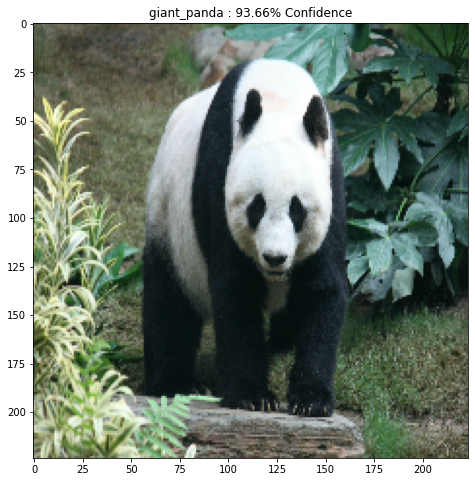

In [ ]:
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

## Create the Adversarial Image. 

We use the FGSM method to create an adversarial image. Be sure to read about FGSM to understand how the attack works. 

In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

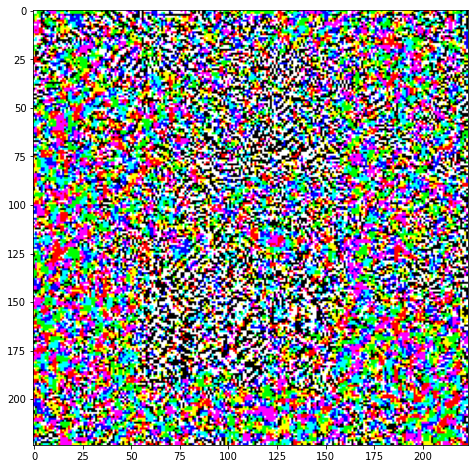

In [ ]:
# Get the input label of the image.
giant_panda_index = 388
label = tf.one_hot(giant_panda_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

In [ ]:
def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

In [ ]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i])

Output hidden; open in https://colab.research.google.com to view.

# Task2: Perform an Analysis to understand the potency of the attack. 

Your task here is to understand how small a change could change the class output and this is measured by the epsilon value needed to change the class. 

Your task is as follows:

* Pick 10 images each from different classes in imagenet. 
* Perform a perturbation analysis on each of these images. 
* In the analysis you are required to report the smallest epsilon value for which you notice a class change. 
* Make a table for each of the images considered with the minimum epsilon value for the FGSM attack. 

Write the Code for the above below. You can add the table also below. 



---


The code below automatically prints/generates a table for the images considered.

In [111]:
# Change this to False to turn off image plotting.
show_plot = False

from tabulate import tabulate

def preprocess_advanced(image, model_type):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = model_type.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label_advanced(probs, model_type):
  return model_type.decode_predictions(probs, top=1)[0][0]

def run_attacks(file_names, class_indexes, show_plot, model = pretrained_model, model_type = tf.keras.applications.mobilenet_v2, diff = 1000):
  data = []

  for file_name, class_index in zip(file_names, class_indexes):
    image_raw = tf.io.read_file('/content/drive/My Drive/Project 2/' + file_name + '.jpeg')
    image = tf.image.decode_image(image_raw)
    image = preprocess_advanced(image, model_type)
    image_probs = model.predict(image)
    _, image_class, image_class_confidence = get_imagenet_label_advanced(image_probs, model_type)

    label = tf.one_hot(class_index, image_probs.shape[-1])
    label = tf.reshape(label, (1, image_probs.shape[-1]))
    perturbations = create_adversarial_pattern(image, label)

    for eps in range(diff + 1):
      eps/=diff
      adv_x = image + eps*perturbations
      adv_x = tf.clip_by_value(adv_x, -1, 1)

      adv_probs = model.predict(adv_x)
      _, adv_class, adv_class_confidence = get_imagenet_label_advanced(adv_probs, model_type)

      if adv_class != image_class:
        if show_plot:
          plt.figure()
          plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
          plt.title('Original Class = {}, Adv Class = {}, Epsilon = {:.3f}, Confidence = {:.2f}%'.format(image_class, adv_class, eps, adv_class_confidence*100))
          plt.show()
        data.append((image_class, adv_class, eps, adv_class_confidence))
        break
    else:
      data.append((image_class, image_class, 1.00, image_class_confidence))

  print(tabulate(data, headers=["Image Class", "Adversarial Class", "Minimum Epsilon", "Class Confidence"]))

In [112]:
file_names = ['german_shepherd', 'goldfish', 'burrito', 'rhinoceros_beetle', 'bald_eagle', 'sleeping_bag', 'analog_clock', 'teddy_bear', 'computer_keyboard', 'mountain_bike']
class_indexes = [235, 1, 965, 306, 22, 797, 409, 850, 508, 671]
run_attacks(file_names, class_indexes, show_plot)


Image Class        Adversarial Class           Minimum Epsilon    Class Confidence
-----------------  ------------------------  -----------------  ------------------
German_shepherd    malinois                              0.013           0.0279756
goldfish           coral_reef                            0.007           0.0973066
burrito            French_loaf                           0.002           0.324989
rhinoceros_beetle  dung_beetle                           0.001           0.478598
bald_eagle         sulphur-crested_cockatoo              0.004           0.0668291
sleeping_bag       folding_chair                         0.003           0.258749
analog_clock       barometer                             0.002           0.241615
teddy              French_loaf                           0.009           0.0294192
computer_keyboard  typewriter_keyboard                   0.001           0.306446
mountain_bike      tricycle                              0.001           0.466324


# Task3: Compare the robustness of the considered model with other models. 

Your task here is to compare how this model (MobileNetV2) compares with other popular object detection models. 

Your task is as follows:

* Consider 5 different models (you can consider various RESNET architectures, any models you find interesting).
* Load the pre-trained weights of the model (trained on imagenet). 
* Perform Task2 on all the considered models. 
* Add all the results in the table. Hence the final table you have 6 columns for each model and epsilon values for each of the 10 images for all 6 models. 


What do you observe? Why do you think this is the case? 

Write the Code for the above below. You can also add the table and answer to the question below. 


---

The code below automatically prints/generates a table for the different models considered.

In [113]:
model_names = ['MobileNetV2', 'MobileNet', 'ResNet50V2', 'ResNet101V2', 'ResNet152V2', 'DenseNet201']
models = [
          tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet'),
          tf.keras.applications.MobileNet(include_top=True, weights='imagenet'),
          tf.keras.applications.ResNet50V2(include_top=True, weights='imagenet'),
          tf.keras.applications.ResNet101V2(include_top=True, weights='imagenet'),
          tf.keras.applications.ResNet152V2(include_top=True, weights='imagenet'),
          tf.keras.applications.DenseNet201(include_top=True, weights='imagenet'),
          ]
model_types = [
               tf.keras.applications.mobilenet_v2,
               tf.keras.applications.mobilenet,
               tf.keras.applications.resnet_v2,
               tf.keras.applications.resnet_v2,
               tf.keras.applications.resnet_v2,
               tf.keras.applications.densenet
              ]

In [115]:
# Change precision to lower value for faster runs
precision = 1000

for model_name, model, model_type in zip(model_names, models, model_types):
  print(model_name)
  print('------------')
  run_attacks(file_names, class_indexes, show_plot, model, model_type, precision)
  print('\n')

MobileNetV2
------------
Image Class        Adversarial Class           Minimum Epsilon    Class Confidence
-----------------  ------------------------  -----------------  ------------------
German_shepherd    malinois                              0.013           0.0279756
goldfish           coral_reef                            0.007           0.0973066
burrito            French_loaf                           0.002           0.324989
rhinoceros_beetle  dung_beetle                           0.001           0.478598
bald_eagle         sulphur-crested_cockatoo              0.004           0.0668291
sleeping_bag       folding_chair                         0.003           0.258749
analog_clock       barometer                             0.002           0.241615
teddy              French_loaf                           0.009           0.0294192
computer_keyboard  typewriter_keyboard                   0.001           0.306446
mountain_bike      tricycle                              0.001     

In general, compared to MobileNetV2, ResNet models take higher minimum epsilon for the class on the adversarial image to change. However, I also did notice that each prediction on ResNet tends to take longer.

This difference may be due to the different neural net configuration. Despite being trained on the same data set, the neural net has different weights and depths and nodes that it provides more accurate/inaccurate results.

Saying that, some models reported a wrong class for the original image (not adversarial). This is again most likely due to the different neural net configuration.

Lastly, for the DenseNet201, for some images, the attack was not successful. Even with an epsilon of 1.0, the adversarial class did not change.

# BONUS: Can you provide a better attack?

Can you design a better attack that lowers the epsilon required for the images?

Task:

* Design another attack. 
* Compare the epsilon values on 10 images. 
* Does it perform better than the FGSM attack? That is, does it have lower epsilon values?

Write the code and provide your answers below. 